## Indonesian Fake News Classification

### Dataset
source: https://www.kaggle.com/datasets/vijayandika/hoax-news-indonesia

### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from wordcloud import WordCloud, STOPWORDS
import nltk
import re

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [3]:
import tensorflow as tf     
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Failed to detect a GPU.


### Dataset

In [4]:
real_news = pd.read_csv("detik.csv")
fake_news = pd.read_csv("turnbackhoax.csv")

In [5]:
real_news['Title']

0           Bekal "Strategic Foresight" untuk Para Capres
1       Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...
2       Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...
3       Relawan Pengusaha Muda Dorong Ekonomi Indonesi...
4       Panda Nababan Sentil Gibran yang Mudah Berkhia...
                              ...                        
2155    Warga Bantargebang Tolak Pembangunan PSEL: Kam...
2156    Polda Metro Dalami Foto Pertemuan SYL dan Firl...
2157    Gelar World Walking Day, Walkot Tangerang: Mud...
2158    Punya Gen Pemicu Alzheimer, Chris Hemsworth Ma...
2159    Gebyar Hari Jantung Sedunia, Bupati Mojokerto ...
Name: Title, Length: 2160, dtype: object

In [6]:
real_news

,Title,Text,Date,Link,Category
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,"detikNewsKamis, 02 Nov 2023 11:15 WIB",https://news.detik.com/kolom/d-7013788/bekal-s...,Politik
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,"detikFinanceKamis, 02 Nov 2023 11:15 WIB",https://finance.detik.com/berita-ekonomi-bisni...,Politik
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,"detikNewsKamis, 02 Nov 2023 11:11 WIB",https://news.detik.com/berita/d-7015092/kapan-...,Politik
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,"detikNewsKamis, 02 Nov 2023 11:04 WIB",https://news.detik.com/berita/d-7015074/relawa...,Politik
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,"detikSumbagselKamis, 02 Nov 2023 10:25 WIB",https://www.detik.com/sumbagsel/berita/d-70149...,Politik
...,...,...,...,...,...
2155,Warga Bantargebang Tolak Pembangunan PSEL: Kam...,"Warga Bantargebang, Kota Bekasi, menolak renca...","detikNewsSabtu, 07 Okt 2023 17:07 WIB",https://news.detik.com/berita/d-6970285/warga-...,Olahraga
2156,Polda Metro Dalami Foto Pertemuan SYL dan Firl...,Polda Metro Jaya dalami foto pertemuan Ketua K...,"detikSumbagselSabtu, 07 Okt 2023 16:49 WIB",https://www.detik.com/sumbagsel/hukum-dan-krim...,Olahraga
2157,"Gelar World Walking Day, Walkot Tangerang: Mud...",Pemerintah Kota (Pemkot) Tangerang sukses meng...,"detikNewsSabtu, 07 Okt 2023 16:06 WIB",https://news.detik.com/berita/d-6970204/gelar-...,Olahraga
2158,"Punya Gen Pemicu Alzheimer, Chris Hemsworth Ma...",Hemsworth disebut memiliki risiko tinggi mengi...,"detikHealthSabtu, 07 Okt 2023 16:00 WIB",https://health.detik.com/berita-detikhealth/d-...,Olahraga


In [7]:
fake_news

,Title,Text,Date,Link,Category
0,[SALAH] Perhelatan Puncak Balapan Formula E Se...,Hasil Periksa Fakta Novita Kusuma Wardhani. In...,"Juni 17, 2022",https://turnbackhoax.id/2022/06/17/salah-perhe...,Olahraga
1,[SALAH] “HRS dilaporkan tewas tertabrak Unta p...,Informasi palsu. Berdasar pada penggunaan kata...,"September 22, 2020",https://turnbackhoax.id/2020/09/22/salah-hrs-d...,Olahraga
2,[SALAH] Formula E Tidak Disiarkan oleh TV Nasi...,Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,"Juni 13, 2022",https://turnbackhoax.id/2022/06/13/salah-formu...,Olahraga
3,[SALAH]: Formula E Jakarta Masuk Rekor Dunia S...,Informasi menyesatkan. Berdasarkan dari pember...,"Juni 6, 2022",https://turnbackhoax.id/2022/06/06/salah-formu...,Olahraga
4,[SALAH]: Barang-barang Pemberian Pembalap Moto...,Bukan barang-barang yang diberikan kepada peno...,"April 1, 2022",https://turnbackhoax.id/2022/04/01/salah-baran...,Olahraga
...,...,...,...,...,...
2147,[SALAH]: Seorang Ibu-Ibu Meninggal Akibat Terp...,Debunk ini berisi informasi yang menyebutkan b...,"Juli 2, 2018",https://turnbackhoax.id/2018/07/02/salah-seora...,Olahraga
2148,[BENAR]: Maradona Bantah Kabar Dirinya Meningg...,Debunk ini berisi bantahan dari Legenda sepakb...,"Juni 29, 2018",https://turnbackhoax.id/2018/06/29/benar-marad...,Olahraga
2149,[BENAR] Wakapolri Tidak Pernah Beri Pernyataan...,Wakapolri Komjen Pol Syafruddin memberikan kla...,"Juni 29, 2018",https://turnbackhoax.id/2018/06/29/benar-wakap...,Olahraga
2150,[BENAR] “Foto wanita Iran yang menonton Piala ...,“Seorang pengguna Reddit mengunggah foto yang ...,"Juni 25, 2018",https://turnbackhoax.id/2018/06/25/benar-foto-...,Olahraga


In [8]:
print("Banyak data berita benar: ", real_news.shape[0])
print("Banyak data berita palsu: ", fake_news.shape[0])

Banyak data berita benar:  2160
Banyak data berita palsu:  2152


#### Histogram

Politik      720
Teknologi    720
Olahraga     720
Name: Category, dtype: int64

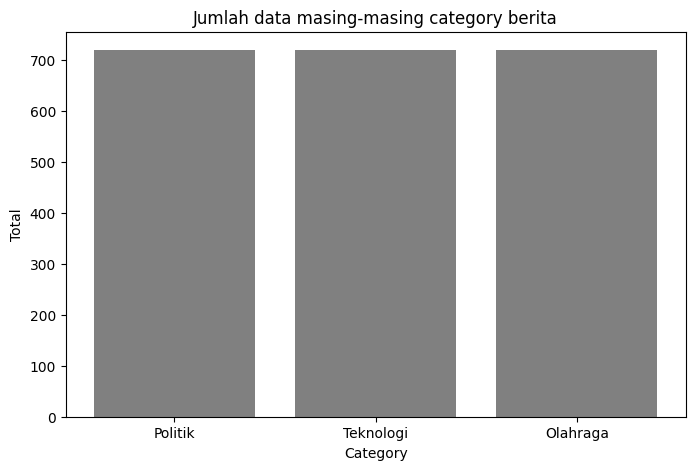

In [9]:
### Tabel Frekuensi
category_series = real_news["Category"]

# Convert to freq table
freq_table = category_series.value_counts()
display(freq_table)

### Bar Chart
# Membangun list nilai x dan y untuk digambar di bar chart
x = freq_table.index.to_list()
y = freq_table.to_list()

# mendefinisikan kanvas untuk menggambar diagram
fig = plt.figure(figsize =(8, 5)) 

# perintah untuk menggambar diagram di kanvas
plt.bar(x, y, color='grey')

# perintah untuk memberi label sumbu x dan y
plt.xlabel("Category")
plt.ylabel("Total")

# perintah untuk memberi judul diagram
plt.title("Jumlah data masing-masing category berita")

# perintah untuk menampilkan gambar di kanvas
plt.show()

### Data Preprocessing

#### Penggabungan tabel

In [10]:
real_news['Is_Fake'] = 0
fake_news['Is_Fake'] = 1
df_concatenated = pd.concat([real_news, fake_news]).reset_index(drop=True)
df_concatenated

,Title,Text,Date,Link,Category,Is_Fake
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,"detikNewsKamis, 02 Nov 2023 11:15 WIB",https://news.detik.com/kolom/d-7013788/bekal-s...,Politik,0
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,"detikFinanceKamis, 02 Nov 2023 11:15 WIB",https://finance.detik.com/berita-ekonomi-bisni...,Politik,0
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,"detikNewsKamis, 02 Nov 2023 11:11 WIB",https://news.detik.com/berita/d-7015092/kapan-...,Politik,0
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,"detikNewsKamis, 02 Nov 2023 11:04 WIB",https://news.detik.com/berita/d-7015074/relawa...,Politik,0
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,"detikSumbagselKamis, 02 Nov 2023 10:25 WIB",https://www.detik.com/sumbagsel/berita/d-70149...,Politik,0
...,...,...,...,...,...,...
4307,[SALAH]: Seorang Ibu-Ibu Meninggal Akibat Terp...,Debunk ini berisi informasi yang menyebutkan b...,"Juli 2, 2018",https://turnbackhoax.id/2018/07/02/salah-seora...,Olahraga,1
4308,[BENAR]: Maradona Bantah Kabar Dirinya Meningg...,Debunk ini berisi bantahan dari Legenda sepakb...,"Juni 29, 2018",https://turnbackhoax.id/2018/06/29/benar-marad...,Olahraga,1
4309,[BENAR] Wakapolri Tidak Pernah Beri Pernyataan...,Wakapolri Komjen Pol Syafruddin memberikan kla...,"Juni 29, 2018",https://turnbackhoax.id/2018/06/29/benar-wakap...,Olahraga,1
4310,[BENAR] “Foto wanita Iran yang menonton Piala ...,“Seorang pengguna Reddit mengunggah foto yang ...,"Juni 25, 2018",https://turnbackhoax.id/2018/06/25/benar-foto-...,Olahraga,1


#### Menghapus kolom yang tidak berguna
Kolom date dan link tidak akan kami pakai karena tidak memberikan pengaruh terhadap pemodelan NLP. Waktu kapan berita diunggah tidak menentukan bahwa berita tersebut hoax atau tidak.

In [11]:
df_concatenated.drop(columns=['Date', 'Link'], inplace=True)

#### Membuat kolom tambahan untuk menggabung judul dan isi berita

In [12]:
df_concatenated['Content'] = df_concatenated['Title'] + " " + df_concatenated['Text']
df_concatenated.head()

,Title,Text,Category,Is_Fake,Content
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,Politik,0,"Bekal ""Strategic Foresight"" untuk Para Capres ..."
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,Politik,0,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,Politik,0,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,Politik,0,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,Politik,0,Panda Nababan Sentil Gibran yang Mudah Berkhia...


#### Case Folding

In [13]:
df_concatenated['Content'] =  df_concatenated['Content'].apply(lambda x: x.lower())
df_concatenated

,Title,Text,Category,Is_Fake,Content
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,Politik,0,"bekal ""strategic foresight"" untuk para capres ..."
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,Politik,0,mendag zulhas jelaskan pengaruh geopolitik ter...
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,Politik,0,kapan pengumuman tkn prabowo-gibran? ini jawab...
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,Politik,0,relawan pengusaha muda dorong ekonomi indonesi...
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,Politik,0,panda nababan sentil gibran yang mudah berkhia...
...,...,...,...,...,...
4307,[SALAH]: Seorang Ibu-Ibu Meninggal Akibat Terp...,Debunk ini berisi informasi yang menyebutkan b...,Olahraga,1,[salah]: seorang ibu-ibu meninggal akibat terp...
4308,[BENAR]: Maradona Bantah Kabar Dirinya Meningg...,Debunk ini berisi bantahan dari Legenda sepakb...,Olahraga,1,[benar]: maradona bantah kabar dirinya meningg...
4309,[BENAR] Wakapolri Tidak Pernah Beri Pernyataan...,Wakapolri Komjen Pol Syafruddin memberikan kla...,Olahraga,1,[benar] wakapolri tidak pernah beri pernyataan...
4310,[BENAR] “Foto wanita Iran yang menonton Piala ...,“Seorang pengguna Reddit mengunggah foto yang ...,Olahraga,1,[benar] “foto wanita iran yang menonton piala ...


#### Erasing Punctuation
Pada bagian ini kita mengambil data title dan juga menghapus setiap karakter "punctuation" dan juga "bracket". Setelah kita sudah memfilter setiap karakter selain alphabet, kita akan memasukannya kedalam satu kolom yang bernama 'Content' supaya data tersebut bisa lebih mudah kita proses.

In [14]:
### Erasing Punctuation
df_concatenated['Content'] = df_concatenated['Content'].str.replace(r'[^a-zA-Z\s]', ' ', regex=True)
df_concatenated


,Title,Text,Category,Is_Fake,Content
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,Politik,0,bekal strategic foresight untuk para capres ...
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,Politik,0,mendag zulhas jelaskan pengaruh geopolitik ter...
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,Politik,0,kapan pengumuman tkn prabowo gibran ini jawab...
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,Politik,0,relawan pengusaha muda dorong ekonomi indonesi...
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,Politik,0,panda nababan sentil gibran yang mudah berkhia...
...,...,...,...,...,...
4307,[SALAH]: Seorang Ibu-Ibu Meninggal Akibat Terp...,Debunk ini berisi informasi yang menyebutkan b...,Olahraga,1,salah seorang ibu ibu meninggal akibat terp...
4308,[BENAR]: Maradona Bantah Kabar Dirinya Meningg...,Debunk ini berisi bantahan dari Legenda sepakb...,Olahraga,1,benar maradona bantah kabar dirinya meningg...
4309,[BENAR] Wakapolri Tidak Pernah Beri Pernyataan...,Wakapolri Komjen Pol Syafruddin memberikan kla...,Olahraga,1,benar wakapolri tidak pernah beri pernyataan...
4310,[BENAR] “Foto wanita Iran yang menonton Piala ...,“Seorang pengguna Reddit mengunggah foto yang ...,Olahraga,1,benar foto wanita iran yang menonton piala ...


#### Menghilangkan Stop Words bahasa Indonesia

In [15]:
stop_words = stopwords.words('indonesian')
stop_words.extend(['dari', 'subjek', 're', 'edu', 'penggunaan', 'salah', 'benar'])


def preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
      result.append(token)
  return result


df_concatenated['Stopword_Filtered'] = df_concatenated['Content'].apply(preprocess)

print("Stopword_Filtered Version:", '\n', df_concatenated['Stopword_Filtered'][0])



Stopword_Filtered Version: 
 ['bekal', 'strategic', 'foresight', 'capres', 'pandangan', 'foresight', 'dimiliki', 'capres', 'cawapres', 'bangsa', 'situasi', 'dunia', 'rentan', 'kompleks']


#### Stemming
Stemming merupakan proses untuk menghilangkan imbuhan pada kata seperti 

In [16]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(token_list):
    return [stemmer.stem(token) for token in token_list]


df_concatenated['Stemmed'] = df_concatenated['Stopword_Filtered'].apply(stemming)

### Save tabel

In [19]:
# df_concatenated.to_csv("./cleaned.csv", index=False)

### EDA

In [62]:
cleaned_df = pd.read_csv("cleaned.csv", converters={'Stemmed': pd.eval})
cleaned_df

,Title,Text,Category,Is_Fake,Content,Stopword_Filtered,Stemmed
0,"Bekal ""Strategic Foresight"" untuk Para Capres",Pandangan jauh ke depan (foresight) perlu dimi...,Politik,0,bekal strategic foresight untuk para capres ...,"['bekal', 'strategic', 'foresight', 'capres', ...","[bekal, strategic, foresight, capres, pandang,..."
1,Mendag Zulhas Jelaskan Pengaruh Geopolitik Ter...,Menteri Perdagangan RI Zulkifli Hasan menjadi ...,Politik,0,mendag zulhas jelaskan pengaruh geopolitik ter...,"['mendag', 'zulhas', 'pengaruh', 'geopolitik',...","[mendag, zulhas, pengaruh, geopolitik, dagang,..."
2,Kapan Pengumuman TKN Prabowo-Gibran? Ini Jawab...,Ketua Harian Partai Gerindra Dasco mengatakan ...,Politik,0,kapan pengumuman tkn prabowo gibran ini jawab...,"['pengumuman', 'prabowo', 'gibran', 'gerindra'...","[umum, prabowo, gibran, gerindra, ketua, hari,..."
3,Relawan Pengusaha Muda Dorong Ekonomi Indonesi...,Relawan Pengusaha Muda Nasional (REPNAS) Indon...,Politik,0,relawan pengusaha muda dorong ekonomi indonesi...,"['relawan', 'pengusaha', 'muda', 'dorong', 'ek...","[rawan, usaha, muda, dorong, ekonomi, indonesi..."
4,Panda Nababan Sentil Gibran yang Mudah Berkhia...,Politikus Senior PDI Perjuangan Panda Nababan ...,Politik,0,panda nababan sentil gibran yang mudah berkhia...,"['panda', 'nababan', 'sentil', 'gibran', 'muda...","[panda, nababan, sentil, gibran, mudah, khiana..."
...,...,...,...,...,...,...,...
4307,[SALAH]: Seorang Ibu-Ibu Meninggal Akibat Terp...,Debunk ini berisi informasi yang menyebutkan b...,Olahraga,1,salah seorang ibu ibu meninggal akibat terp...,"['meninggal', 'akibat', 'terperosok', 'setu', ...","[tinggal, akibat, perosok, setu, babakan, jaga..."
4308,[BENAR]: Maradona Bantah Kabar Dirinya Meningg...,Debunk ini berisi bantahan dari Legenda sepakb...,Olahraga,1,benar maradona bantah kabar dirinya meningg...,"['maradona', 'bantah', 'kabar', 'meninggal', '...","[maradona, bantah, kabar, tinggal, laga, argen..."
4309,[BENAR] Wakapolri Tidak Pernah Beri Pernyataan...,Wakapolri Komjen Pol Syafruddin memberikan kla...,Olahraga,1,benar wakapolri tidak pernah beri pernyataan...,"['wakapolri', 'pernyataan', 'terkait', 'pilkad...","[wakapolri, nyata, kait, pilkada, kota, makass..."
4310,[BENAR] “Foto wanita Iran yang menonton Piala ...,“Seorang pengguna Reddit mengunggah foto yang ...,Olahraga,1,benar foto wanita iran yang menonton piala ...,"['foto', 'wanita', 'iran', 'menonton', 'piala'...","[foto, wanita, iran, tonton, piala, dunia, hij..."


#### Wordcloud

##### Berita Benar

In [72]:
real_text = ""
for _, row in cleaned_df[cleaned_df['Is_Fake'] == 0].iterrows():
    real_text += " ".join(row['Stemmed'])

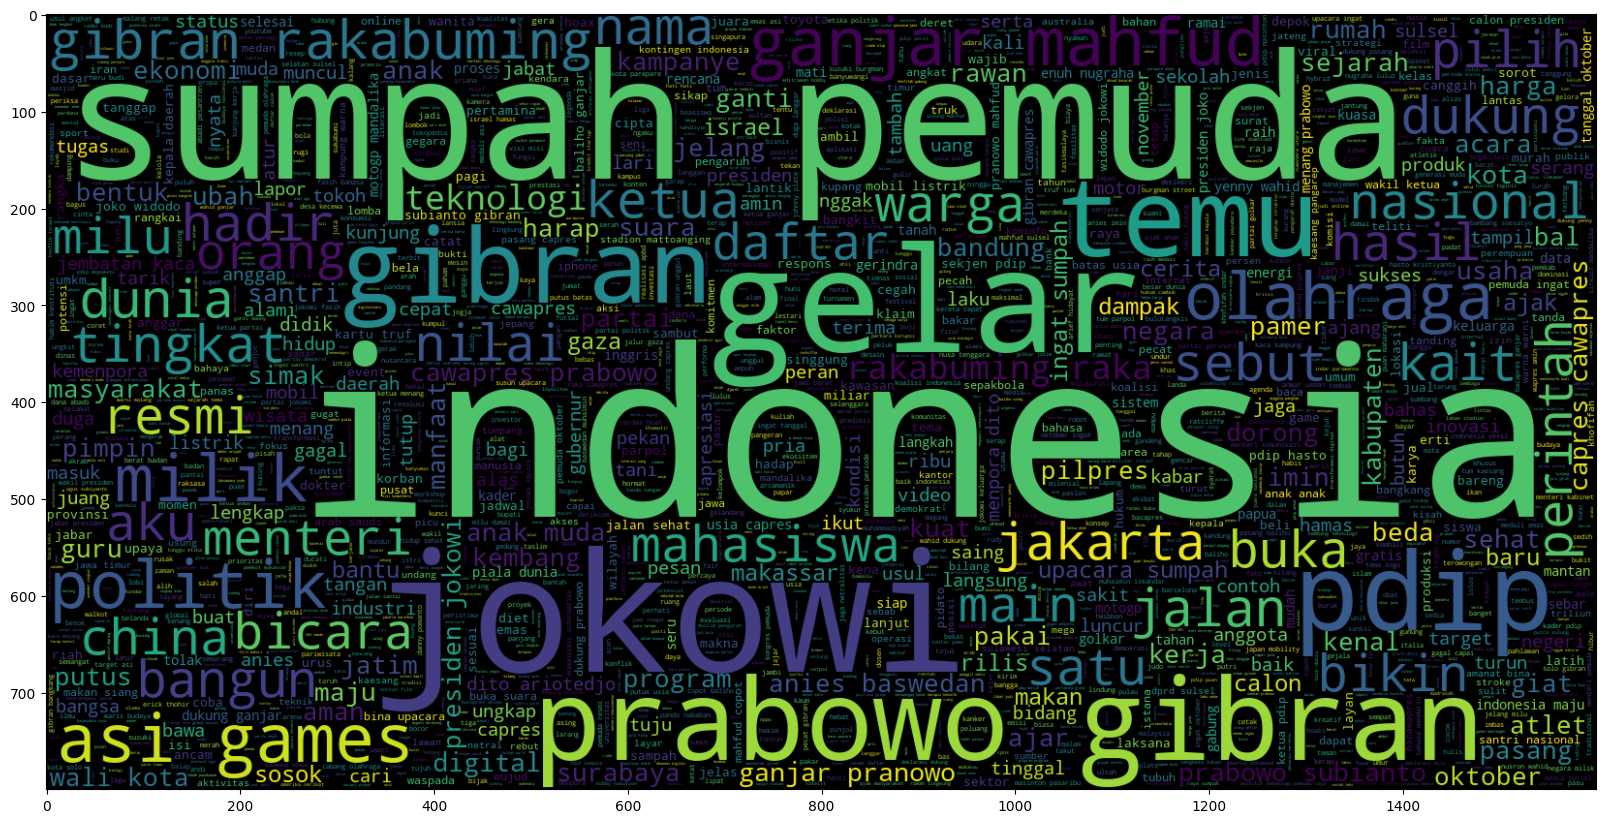

In [73]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(max_words=2000, width=1600, height=800).generate(real_text)
plt.imshow(wordcloud, interpolation='bilinear')

In [74]:
fake_text = ""
for _, row in cleaned_df[cleaned_df['Is_Fake'] == 1].iterrows():
    fake_text += " ".join(row['Stemmed'])

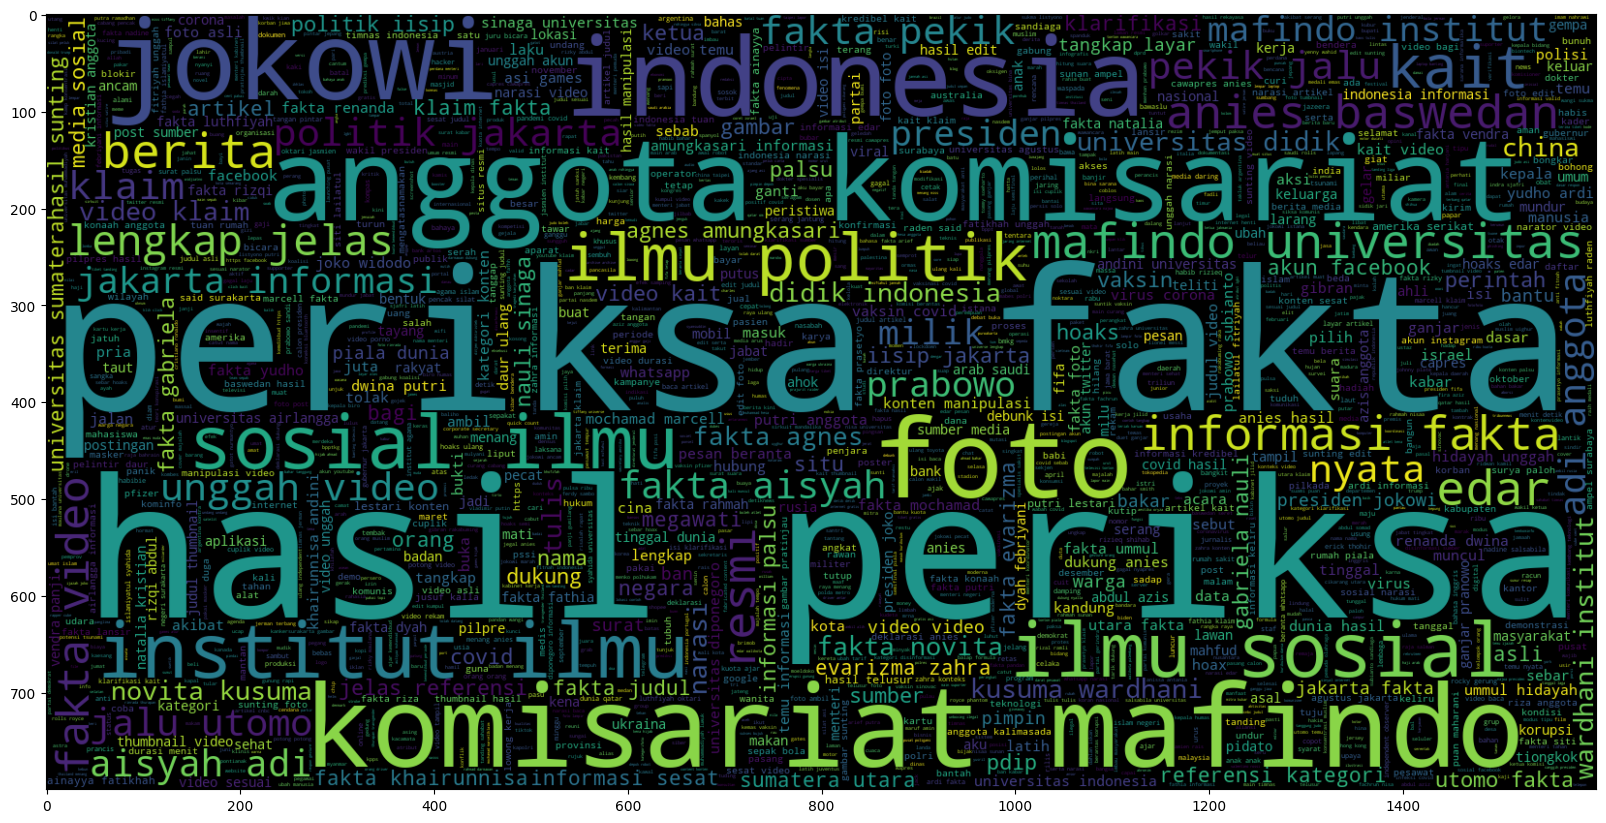

In [75]:
plt.figure(figsize=(20,20))
wordcloud2 = WordCloud(max_words=2000, width=1600, height=800).generate(fake_text)
plt.imshow(wordcloud2, interpolation='bilinear')

### Modelling